In [1]:
##################################3
####################################    
########################
from PIL import Image, ImageDraw
from osgeo import gdal, gdalnumeric, ogr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import pandas as pa
import re
import seaborn as sea
import shapefile

def clip_raster(rast, poly):
    # from http://geospatialpython.com/
    def array_to_image(a):
        i = Image.fromstring('L',(a.shape[1], a.shape[0]),
            (a.astype('b')).tostring())
        return i
    def image_to_array(i):
        a = gdalnumeric.fromstring(i.tobytes(), 'b')
        a.shape = i.im.size[1], i.im.size[0]
        return a
    def world_to_pixel(geo_matrix, x, y):
        ulX = geo_matrix[0]
        ulY = geo_matrix[3]
        xDist = geo_matrix[1]
        yDist = geo_matrix[5]
        rtnX = geo_matrix[2]
        rtnY = geo_matrix[4]
        pixel = int((x - ulX) / xDist)
        line = int((ulY - y) / xDist)
        return (pixel, line)

    gt = rast.GetGeoTransform()
    rast = rast.ReadAsArray()
    minX, minY, maxX, maxY = poly.bbox
    # Convert the layer extent to image pixel coordinates
    #minX, maxX, minY, maxY = lyr.GetExtent()
    ulX, ulY = world_to_pixel(gt, minX, maxY)
    lrX, lrY = world_to_pixel(gt, maxX, minY)
    # Calculate the pixel size of the new image
    pxWidth = int(lrX - ulX)
    pxHeight = int(lrY - ulY)
    clip = rast[:, ulY:lrY, ulX:lrX]
    # Create a new geomatrix for the image
    gt2 = list(gt)
    gt2[0] = minX
    gt2[3] = maxY
    # Map points to pixels for drawing the boundary on a blank 8-bit,
    #   black and white, mask image.
    pixels = []
    points = poly.points
    for p in points:
        pixels.append(world_to_pixel(gt2, p[0], p[1]))
    raster_poly = Image.new('L', (pxWidth, pxHeight), 1)
    rasterize = ImageDraw.Draw(raster_poly)
    rasterize.polygon(pixels, 0) # Fill with zeroes
    mask = image_to_array(raster_poly)
    # Clip the image using the mask
    clip = gdalnumeric.choose(mask, (clip, np.nan))
    #return (clip, ulX, ulY, gt2)
    return clip

def GetRasExtent(ras): # xmin xmax, ymin, ymax
    tf = ras.GetGeoTransform()
    xL = tf[0]
    yT = tf[3]
    xR = xL + ras.RasterXSize*tf[1] # cols * width
    yB = yT + ras.RasterYSize*tf[5] # rows * height
    return (xL, yB, xR, yT) # xmin, ymin, xmax, ymax


In [2]:
#%matplotlib qt # doesn't work on server
%matplotlib inline

In [3]:
# Get all houses in Portland
c = shapefile.Reader('/home/vagrant/PortlandBuildings/Building_Footprints_pdx')
c.bbox # bounding box of the shapefile
records = c.records() # get the 'data' from the shapefile
len(records) # number of buildings in Portland

655818

In [8]:
recpa = pa.DataFrame(records, columns=pa.DataFrame(c.fields).ix[1:,0])
#recpa.head()
recpa.BLDG_SQFT = pa.to_numeric(recpa.BLDG_SQFT,'coerce') # force to numeric - necessary?
selection = recpa.index[(recpa.BLDG_USE.isin(("Single Family Residential","Multi Family Residential"))) 
                        & (recpa.BLDG_SQFT>700)& (recpa.BLDG_SQFT<7000)] # exclude sheds and mansions
len(selection) # number of houses
#plt.hist(recpa.BLDG_SQFT[selection],bins=range(0,int(max(recpa.BLDG_SQFT[selection])),1000))

# make new shapefile with all houses
sw = shapefile.Writer(c.shapeType)
sw.fields = list(c.fields)
for s in selection:
    css = c.shape(s)
    bbox = css.bbox
    sw._shapes.append(css)
    sw.records.append(c.record(s))
sh = sw.shapes()
len(sh)

162221

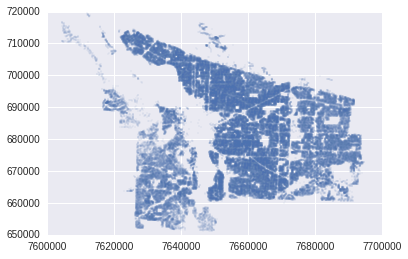

In [10]:
# plot all houses
coox = []
for h in sh:
    coox.append(h.points[0]) # get corner coordinate from each house
cools = pa.DataFrame(coox,columns=["x","y"])

plt.plot(cools.x,cools.y,".",ms=1)
#plt.savefig('ORhouses.png')

In [11]:
# get all rasters
# so much faster than shapefile!
d = "/home/vagrant/rast/"
dirs = os.listdir(d)
#onlyfiles = [f for f in os.listdir(/) if os.isfile(os.join(mypath, f))]

# get raster extents
rex = []
for di in dirs:
    ff = os.listdir(d+di)
    ra = [x for x in ff if re.match(".+tif",x)]
    fi = d+di+"/"+ra[0]
    ras = gdal.Open(fi)
    rex.append(GetRasExtent(ras))
    #ras.GetProjection()
#len(rex)

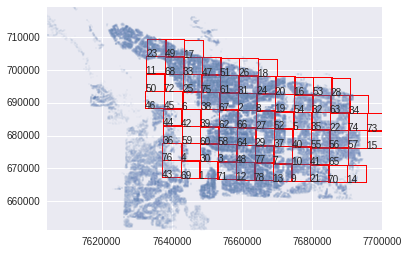

In [12]:
p11 = plt.figure()
ax = p11.add_subplot(111)
ax.set_xlim([min(cools.x),7700000])
ax.set_ylim([min(cools.y),max(cools.y)])
ax.plot(cools.x,cools.y,".",ms=1,alpha=0.5)

# plot all scenes on top of houses
ind = 1
for r in rex:
    ax.add_patch(patches.Rectangle((r[0],r[1]),r[2]-r[0],r[3]-r[1],fill=False,color="red",linewidth=1))
    ax.text((r[0]),(r[1]),ind)
    ind+=1
# another way to do this    
#for s in selection[:5000]:
#    ax.add_patch(patches.Polygon(np.array(c.shape(s).points),fill=True,linewidth=1))
    #x,y = c.shape(s).points[0]
    #ax.plot(x,y,"b.")
#plt.savefig('ORhousesTiles.png')

In [33]:
###################
# Bring in a raster
# ras = gdal.Open("/home/aaron/Downloads/OR/vol001/1n2e36u.tif")
# ras.GetProjection()
# rasextent = GetRasExtent(ras)
# # plot false color image
# rasdat = ras.ReadAsArray()
# rasdat.shape

# falsecol = np.array([rasdat[3,:,:],rasdat[0,:,:],rasdat[1,:,:]])
# falsecol.shape

# plt.imshow(falsecol.T)
# plt.axis([0,1000,9000,10000])

#lay = ras.GetLayer()
#ras.shape
#gt = ras.GetGeoTransform()
#rascol = ras.RasterXSize
#rasrow = ras.RasterYSize
ff = os.listdir(d+dirs[0])
ra = [x for x in ff if re.match(".+tif",x)]
fi = d+dirs[0]+"/"+ra[0]
ras = gdal.Open(fi)
#ra
#ras

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f0ab216a210> >

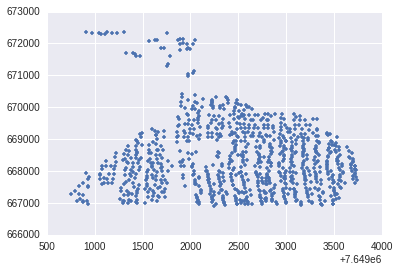

In [36]:
rx = GetRasExtent(ras)

# make new shape with only houses in raster
w = shapefile.Writer(c.shapeType)
w.fields = list(c.fields)
for s in selection:
    css = c.shape(s)
    bbox = css.bbox
    if bbox[0] < rx[0]: continue # minx
    elif bbox[1] < rx[1]: continue # miny
    elif bbox[2] > rx[2]: continue # maxx
    elif bbox[3] > rx[3]: continue #maxy
    w._shapes.append(css)
    w.records.append(c.record(s))

sh = w.shapes()
len(sh)

# idea, loop through all houses, choose box to put it in, add it.
coox = []
for h in sh:
    coox.append(h.points[0])
cools = pa.DataFrame(coox,columns=["x","y"])
plt.plot(cools.x,cools.y,".")


In [14]:
####### IDENTIFY PIXELS AS HOUSE OR NOT
####### NEED GUI or -X connection
csz = 500 # number of pixels to view at once, in 0.5 foot increments
xo = []
#th = open("/home/aaron/Desktop/treehousedata.txt")
#xo = simplejson.load(th)

def dap(event):
    if event.button == 1: 
        if event.xdata is None:
            plt.close(fig)
            print "nonesies"
            xlow = np.random.randint(0,falsecol.T.shape[0]-csz) # random in area
            ylow = np.random.randint(0,falsecol.T.shape[1]-csz) # random in area
            ax.set_xlim([xlow,xlow+csz])
            ax.set_ylim([ylow,ylow+csz])
            fig.show()
        else:
            xo.append(["T",event.xdata,event.ydata])
            print "You added a tree!"
    elif event.button == 3: 
        xo.append(["H",event.xdata,event.ydata])
        print "You added a house!"

print "\nSelect trees by left clicking.\nSelect houses by right clicking.\m"

# repeat this process to add new data to set.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(falsecol.T)
cid = fig.canvas.mpl_connect('button_press_event', dap)
#randomly set axis
xlow = np.random.randint(0,falsecol.T.shape[0]-csz) # random in area
ylow = np.random.randint(0,falsecol.T.shape[1]-csz) # random in area
ax.set_xlim([xlow,xlow+csz])
ax.set_ylim([ylow,ylow+csz])
fig.show()


In [45]:
#fig.canvas.mpl_disconnect(cid)


In [ ]:
# FUNCTION TO EXTRACT DATA FOR ANY POLYGON,
# in this case, a single house 'sh[0]'
ras2 = clip_raster(ras,sh[0])

# is this necessary?
outs = pa.DataFrame(ras2.reshape((-1,4)),columns=("r","g","b","i"))
sr = outs.i*1./outs.r


In [ ]:
# get data from training set
dat = pa.DataFrame(xo,columns=['type','x','y'])
dat.x = dat.x.astype(int)
dat.y = dat.y.astype(int)
sr = np.log(rasdat[3]*1./rasdat[0])
trees = sr[dat.x[dat.type=='T'],dat.y[dat.type=='T']]
houss = sr[dat.x[dat.type=='H'],dat.y[dat.type=='H']]

bins = np.arange(-2,4,0.1)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(houss,bins=bins,alpha=0.6,label="Houses")
ax.hist(trees,bins=bins,alpha=0.6,label="Trees")
ax.set_xlim([-0.5,2.5])
ax.legend(loc='upper right',fontsize=20)
ax.set_xlabel('Spectral index (NIR / Red)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig('test.pdf',format="pdf")
fig.show()


In [ ]:
####
# KNN classification
# KNN analysis
allval = sr[dat.x,dat.y]

from sklearn.cross_validation import cross_val_score, KFold
from sklearn import neighbors
from sklearn import metrics
nn = neighbors.KNeighborsClassifier(n_neighbors=10)
nn.fit(allval.reshape(-1,1),dat.type)
y_obs = dat.type
y_pred = nn.predict(allval.reshape(-1,1))


scores = cross_val_score(nn,allval.reshape(-1,1),dat.type,cv=10,scoring='accuracy')
scores.mean()

metrics.confusion_matrix(y_obs,y_pred)
